In [1]:
import os
import sys
import yaml
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rerf.rerfClassifier import rerfClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.utils import check_random_state

from mne_bids.path import BIDSPath
from mne import Epochs

src = "/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/"
if not src in sys.path:
    sys.path.append(src)

from mtsmorf.io.move.read import read_trial_metadata, read_move_trial_epochs
from mtsmorf.move_exp.cohort_functions import (
    read_cohort_directionality_data,
    read_cohort_movement_data,
    read_cohort_planning_data
)

from mtsmorf.io.move.read import read_move_trial_epochs, read_trial_metadata
from mtsmorf.io.utils import NumpyEncoder

%load_ext autoreload
%autoreload 2

In [2]:
cohort = [
    "efri07",
    "efri13",
    "efri14",
    "efri18",
    "efri20",
]

with open(Path(os.path.abspath(' ')).parents[3] / "mtsmorf/move_exp/config.yml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

root = Path(config["bids_root"])
results_path = Path(config["results_path"])

seed = 1
n_splits = 5
cv = GroupKFold(n_splits)
metrics = dict(accuracy="accuracy", 
            cohen_kappa_score=make_scorer(cohen_kappa_score),
            roc_auc_ovr="roc_auc_ovr")

resample_rate = 500

In [3]:
channels = {
    "efri07" : [
        "F1", "E3",       # Fusiform gyrus
        "E5", "E6",       # ITG
        "B7", "B8",       # MTG
        "U4", "U5"        # STG
    ],
    "efri13" : [
        "F'1", "E'4",
        "E'8", "E'7",
        "F'7", "F'9",
        "U'3", "U'4",
    ],
    "efri14" : [
        "F'1", "F'2",
        "F'3", "F'6",
        "B'7", "B'8",
        "U'8", "U'7"
    ],
    "efri18" : [
        "F'1", "F'2",
        "B'6", "B'7",
        "TP'9", "F'14",
        "U'8", "U'6"
    ],
    "efri20" : [
        "E4", "O1",
        "O8", "O9",
        "C12", "C14",
        "C10", "C9"
    ],
}

## Decode Directionality

)
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/

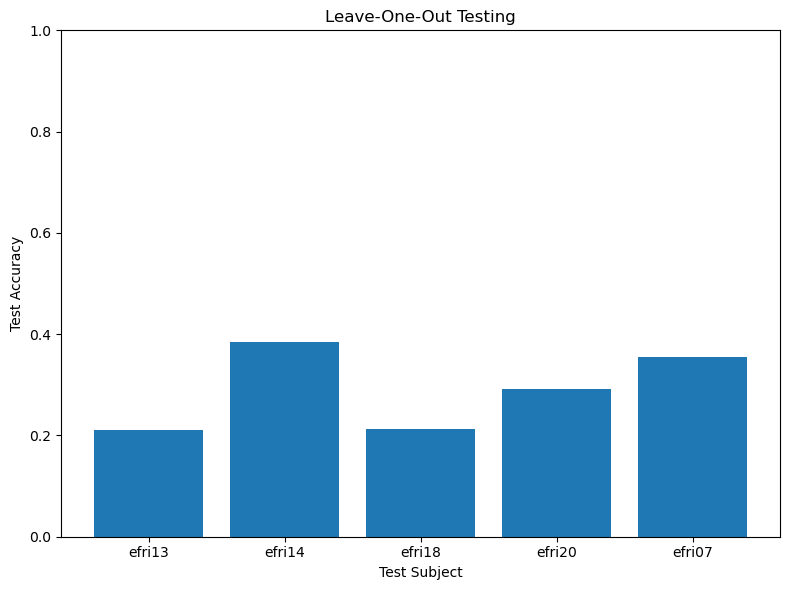

<Figure size 432x288 with 0 Axes>

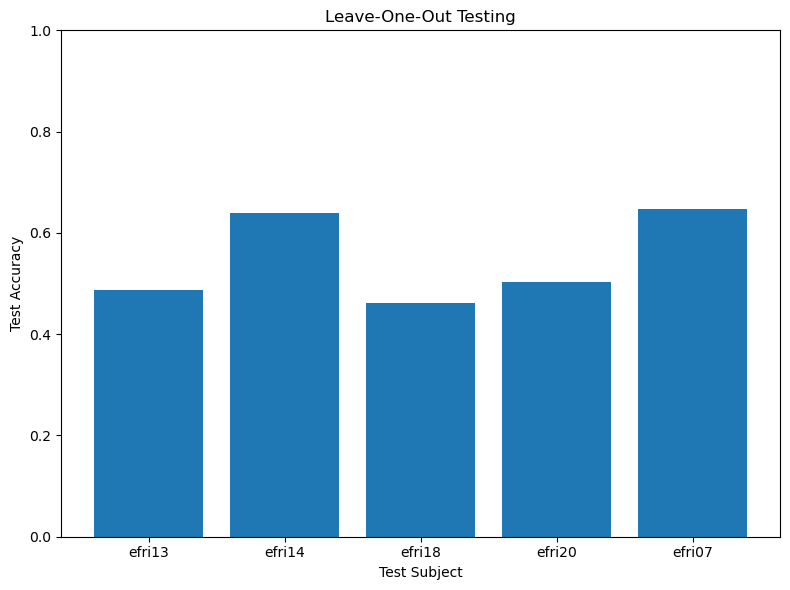

<Figure size 432x288 with 0 Axes>

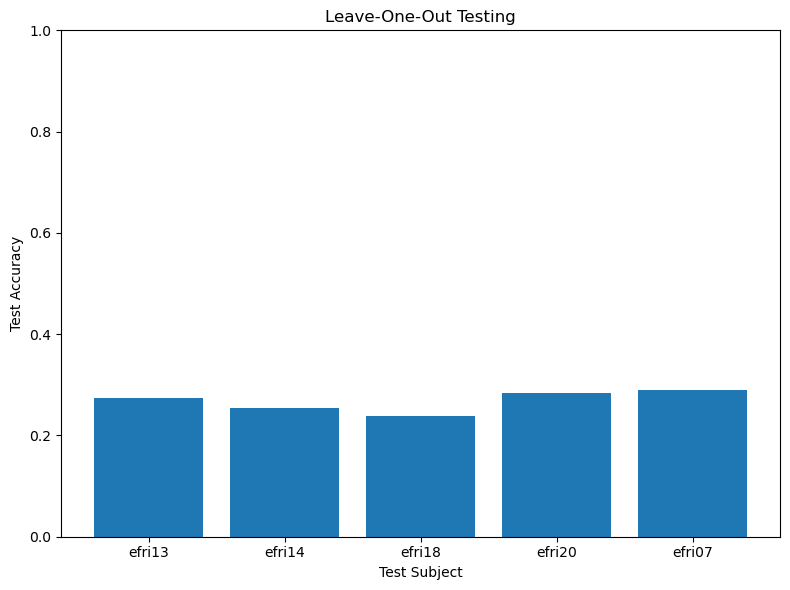

<Figure size 432x288 with 0 Axes>

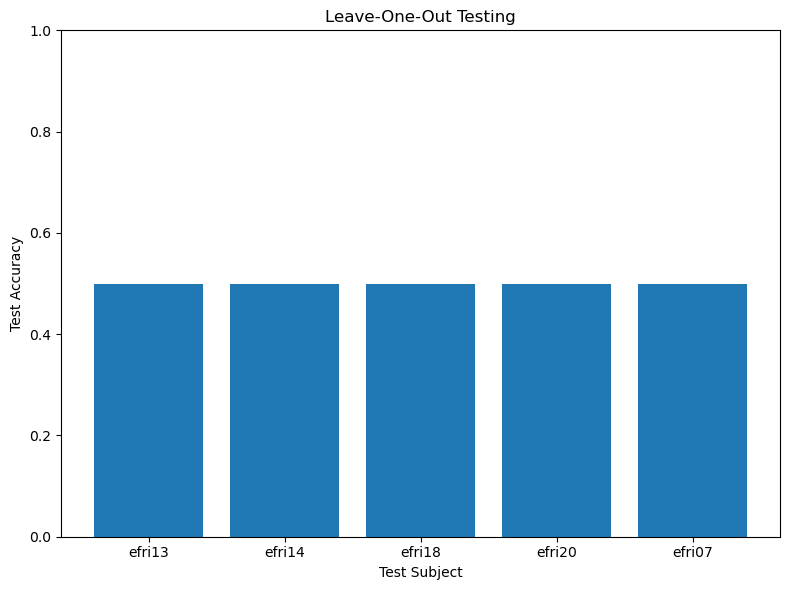

<Figure size 432x288 with 0 Axes>

In [4]:
destination_path = results_path / "cohort_decode_directionality"
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

data, labels, groups = read_cohort_directionality_data(root, cohort, channels, resample_rate=resample_rate)

random_state = 1
image_height, image_width = data.shape[1:]
clf = rerfClassifier(
    n_estimators=500,
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=random_state,
    image_height=image_height,
    image_width=image_width,
)

X = data.reshape(data.shape[0], -1)
y = labels

# Plot for MT-MORF
scores = cross_validate(clf, X, y, groups=groups, scoring=metrics, cv=cv, 
                        return_train_score=True, return_estimator=True)
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], scores["test_accuracy"])
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_MT-MORF.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], scores["test_roc_auc_ovr"])
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_MT-MORF.png")

# Plot for Dummy
dummy = DummyClassifier(strategy="most_frequent", random_state=random_state)
dummy_scores = cross_validate(dummy, X, y, groups=groups, scoring=metrics, cv=cv, 
                            return_train_score=True, return_estimator=True)
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], dummy_scores["test_accuracy"])
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_dummy.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], dummy_scores["test_roc_auc_ovr"])
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_dummy.png")

## Decode Movement

Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/mot

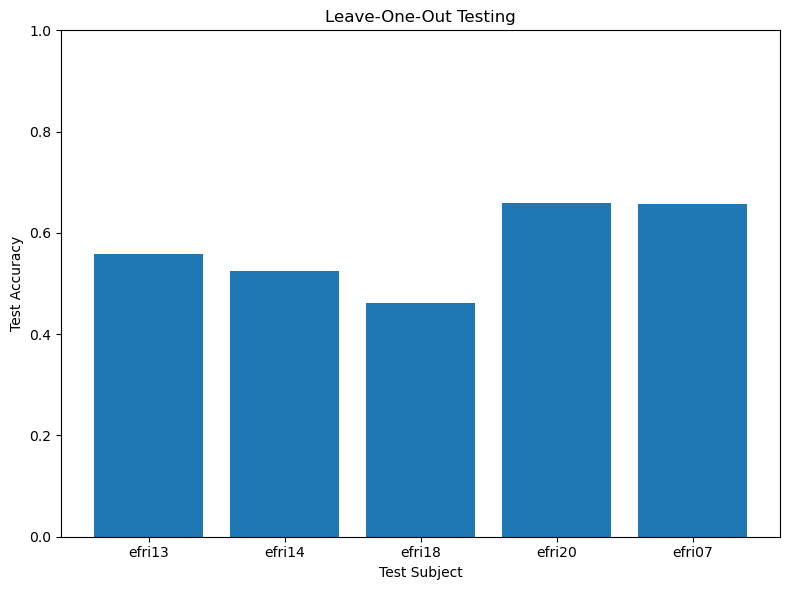

<Figure size 432x288 with 0 Axes>

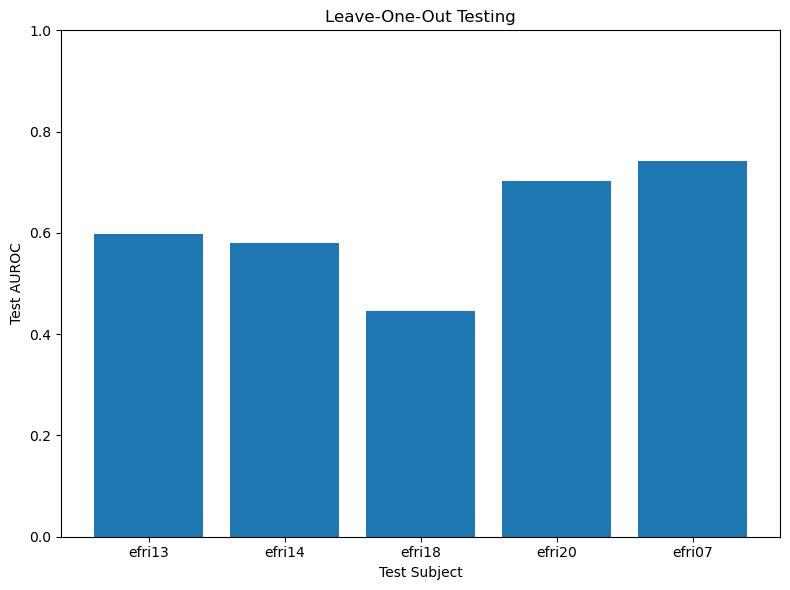

<Figure size 432x288 with 0 Axes>

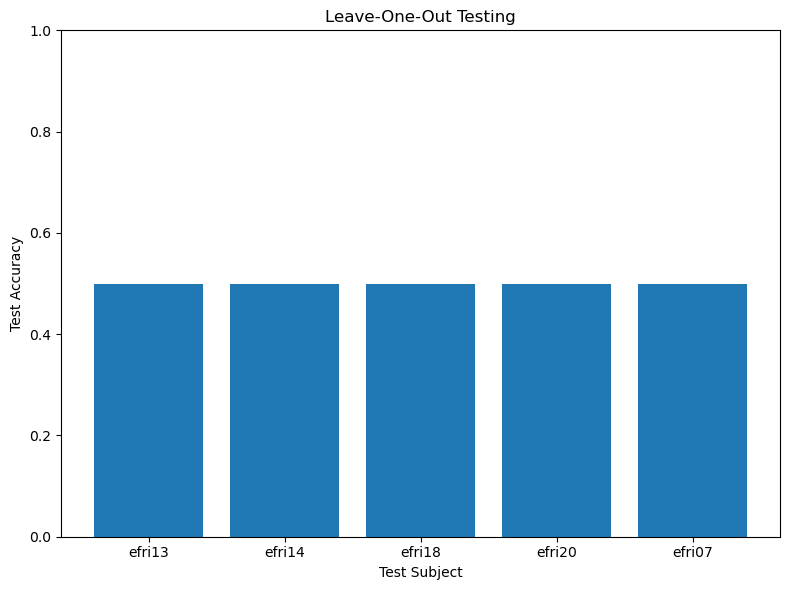

<Figure size 432x288 with 0 Axes>

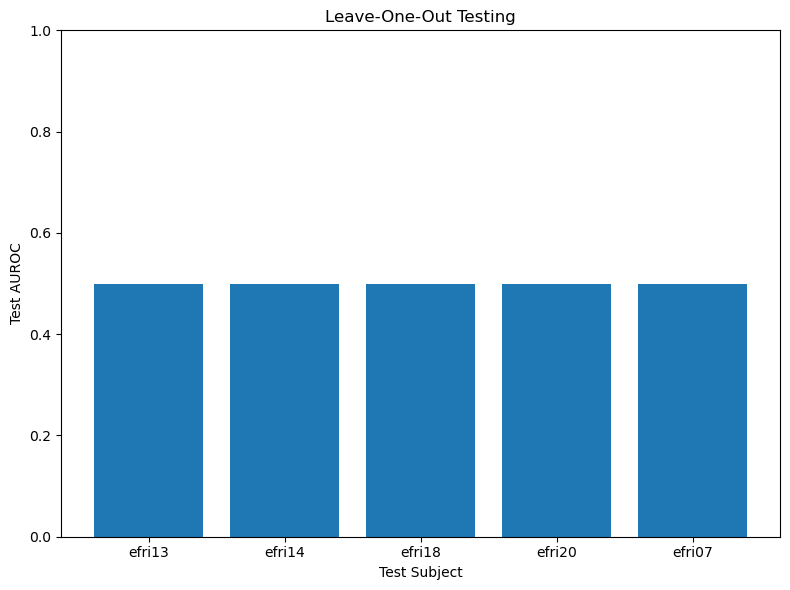

<Figure size 432x288 with 0 Axes>

In [4]:
destination_path = results_path / "cohort_decode_movement"
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

data, labels, groups = read_cohort_movement_data(root, cohort, channels, resample_rate=resample_rate)

random_state = 1
image_height, image_width = data.shape[1:]
clf = rerfClassifier(
    n_estimators=500,
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=random_state,
    image_height=image_height,
    image_width=image_width,
)

X = data.reshape(data.shape[0], -1)
y = labels

# Plot for MT-MORF
scores = cross_validate(clf, X, y, groups=groups, scoring=metrics, cv=cv, 
                        return_train_score=True, return_estimator=True)
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], scores["test_accuracy"])
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_MT-MORF.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], scores["test_roc_auc_ovr"])
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_MT-MORF.png")

# Plot for Dummy
dummy = DummyClassifier(strategy="most_frequent", random_state=random_state)
dummy_scores = cross_validate(dummy, X, y, groups=groups, scoring=metrics, cv=cv, 
                            return_train_score=True, return_estimator=True)
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], dummy_scores["test_accuracy"])
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_dummy.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], dummy_scores["test_roc_auc_ovr"])
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_dummy.png")

## Planning Movement

/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:94: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-de

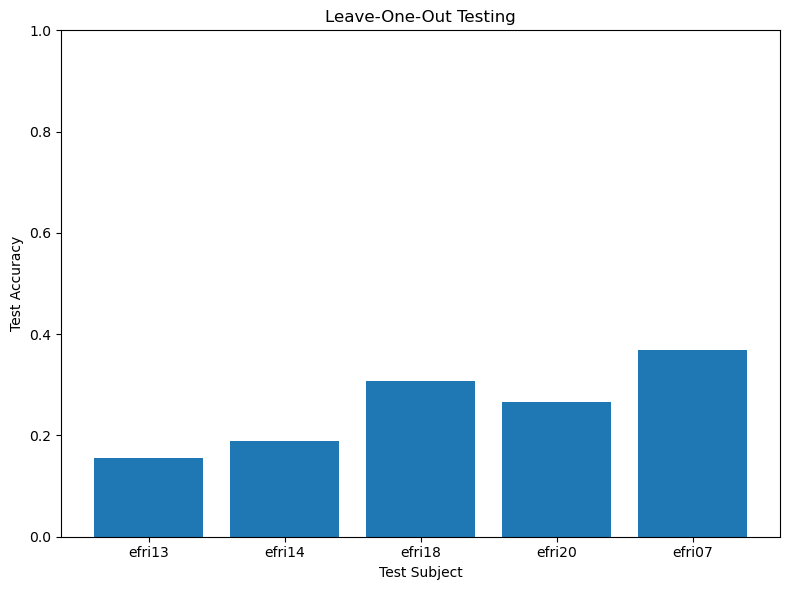

<Figure size 432x288 with 0 Axes>

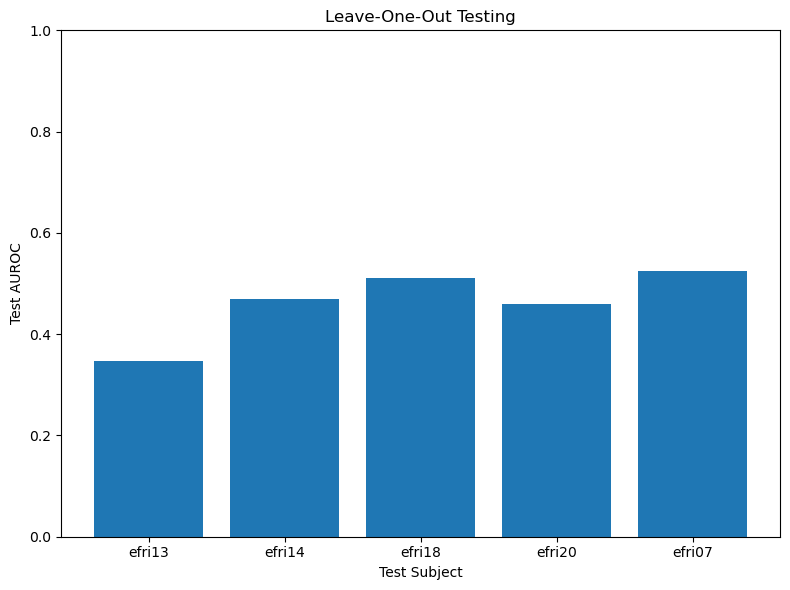

<Figure size 432x288 with 0 Axes>

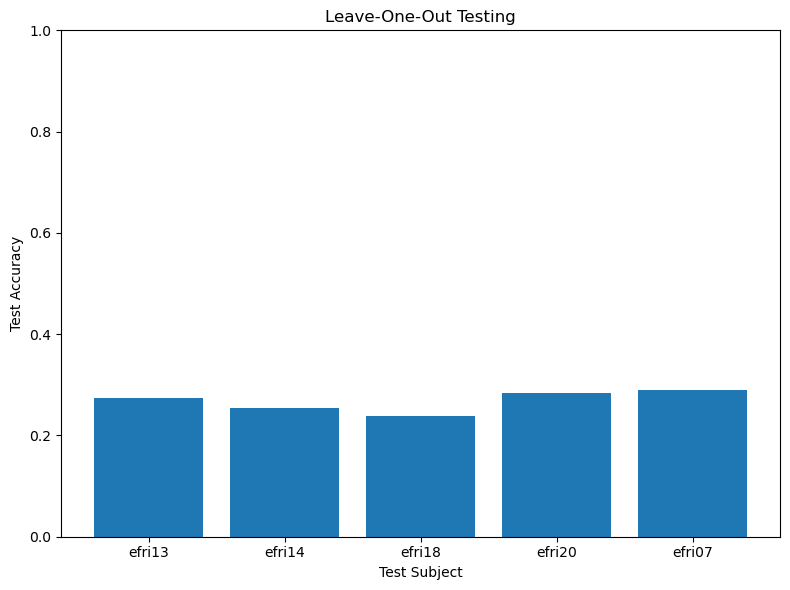

<Figure size 432x288 with 0 Axes>

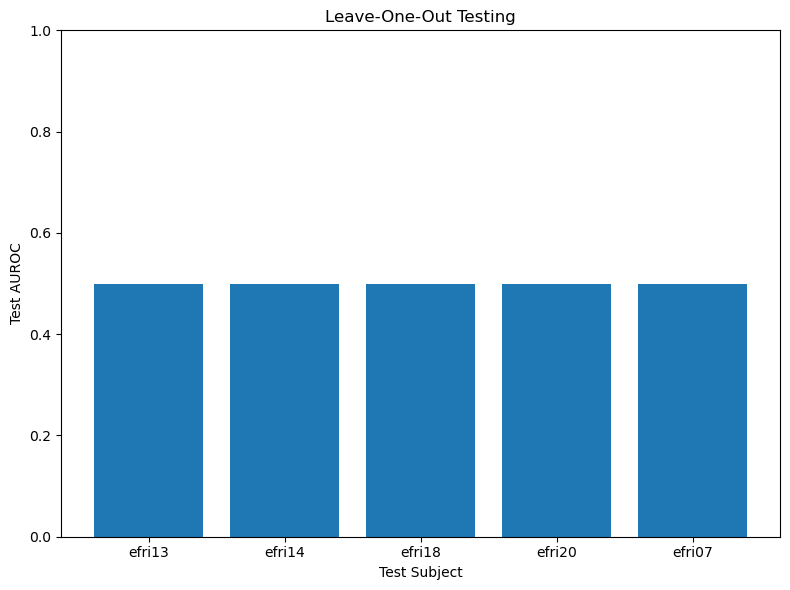

<Figure size 432x288 with 0 Axes>

In [5]:
destination_path = results_path / "cohort_planning_movement"
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

data, labels, groups = read_cohort_planning_data(root, cohort, channels, resample_rate=resample_rate)

random_state = 1
image_height, image_width = data.shape[1:]
clf = rerfClassifier(
    n_estimators=500,
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=random_state,
    image_height=image_height,
    image_width=image_width,
)

X = data.reshape(data.shape[0], -1)
y = labels

# TODO: plot diff in accuracies and auroc

# Plot for MT-MORF
scores = cross_validate(clf, X, y, groups=groups, scoring=metrics, cv=cv, 
                        return_train_score=True, return_estimator=True)
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], scores["test_accuracy"])
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_MT-MORF.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], scores["test_roc_auc_ovr"])
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_MT-MORF.png")

# Plot for Dummy
dummy = DummyClassifier(strategy="most_frequent", random_state=random_state)
dummy_scores = cross_validate(dummy, X, y, groups=groups, scoring=metrics, cv=cv, 
                            return_train_score=True, return_estimator=True)
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], dummy_scores["test_accuracy"])
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_dummy.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], dummy_scores["test_roc_auc_ovr"])
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_dummy.png")